In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time


#### Github Origin Repo
https://github.com/ritvikmath/Time-Series-Analysis

### Load data

In [2]:

df_aug_ca = pd.read_csv('data/aug_21/aug_21_filtered.csv')
df_aug_ca = df_aug_ca.drop(df_aug_ca.columns[0], axis=1)

df_aug_ca['time_utc'] = pd.to_datetime(df_aug_ca['time_utc'], infer_datetime_format= True)

df_aug_ca.insert(3, 'rounded_lat', df_aug_ca['lat'].round())
df_aug_ca.insert(4, 'rounded_lon', df_aug_ca['lon'].round())

df_aug_ca.insert(3, 'rounded_lat_1', df_aug_ca['lat'].round(1))
df_aug_ca.insert(4, 'rounded_lon_1', df_aug_ca['lon'].round(1))

print("ORIGINAL DATA SHAPE", df_aug_ca.shape)
df_aug_ca.head()


ORIGINAL DATA SHAPE (98727, 11)


,time_utc,lat,lon,rounded_lat_1,rounded_lon_1,rounded_lat,rounded_lon,qa_val,methane_mixing_ratio,methane_mixing_ratio_precision,methane_mixing_ratio_bias_corrected
0,2021-08-01 19:57:42.668,32.866806,-114.359250,32.9,-114.4,33.0,-114.0,0.4,1858.0217,1.434432,1860.8737
1,2021-08-01 19:57:43.508,32.799152,-114.617550,32.8,-114.6,33.0,-115.0,0.4,1869.6572,1.434827,1873.1146
2,2021-08-01 19:57:43.508,32.914066,-114.380090,32.9,-114.4,33.0,-114.0,0.4,1850.1168,1.449401,1853.2874
3,2021-08-01 19:57:44.348,32.846360,-114.638510,32.8,-114.6,33.0,-115.0,0.4,1876.0233,1.410911,1878.4884
4,2021-08-01 19:57:47.708,33.035030,-114.722824,33.0,-114.7,33.0,-115.0,0.4,1852.6785,1.527326,1857.2365


In [3]:
df_aug_ca.nunique()

time_utc                                6878
lat                                    95965
lon                                    92598
rounded_lat_1                             93
rounded_lon_1                            108
rounded_lat                               10
rounded_lon                               11
qa_val                                     2
methane_mixing_ratio                   90867
methane_mixing_ratio_precision         97827
methane_mixing_ratio_bias_corrected    90631
dtype: int64

### Geo Group

In [4]:
gdf_geo = df_aug_ca.groupby([df_aug_ca.time_utc.dt.date, 'rounded_lat_1', 'rounded_lon_1']) \
                 .agg({'methane_mixing_ratio_bias_corrected':'mean'}) \
                 .reset_index()

print('gdf_geo', gdf_geo.shape)
gdf_geo.head()


gdf_geo (61698, 4)


,time_utc,rounded_lat_1,rounded_lon_1,methane_mixing_ratio_bias_corrected
0,2021-08-01,32.8,-117.0,1866.96295
1,2021-08-01,32.8,-114.6,1875.80150
2,2021-08-01,32.9,-117.0,1866.79845
3,2021-08-01,32.9,-116.0,1881.01930
4,2021-08-01,32.9,-115.8,1880.81560


### Time Group

In [5]:
gdf_time = df_aug_ca.groupby([df_aug_ca.time_utc.dt.date]) \
                 .agg({'methane_mixing_ratio_bias_corrected':'mean'}) \
                 .reset_index()

gdf_time = gdf_time.set_index(['time_utc'])
print('gdf_time', gdf_time.shape)
gdf_time.head()

gdf_time (30, 1)


,methane_mixing_ratio_bias_corrected
time_utc,
2021-08-01,1865.911443
2021-08-02,1861.778626
2021-08-04,1843.632174
2021-08-05,1850.621098
2021-08-06,1887.348444


## SARIMA Modelling

Seasonal Autoregressive Integrated Moving Average in order to predict the "last 6 monthes given the last 3 years".


* https://www.youtube.com/watch?v=XPwCo4cqqt0
* https://github.com/ritvikmath/Time-Series-Analysis/blob/master/Anomaly%20Detection.ipynb

In [6]:
#infer the frequency of the data
gdf_time = gdf_time.asfreq(pd.infer_freq(gdf_time.index))

#Time Range
start_date = datetime(2021,8,1)
end_date = datetime(2021,8,31)
date_range = pd.date_range(start = start_date, end=end_date, freq='W').tolist() # 'W' --> week, 'D' --> day

lim_methane = gdf_time[start_date:end_date]

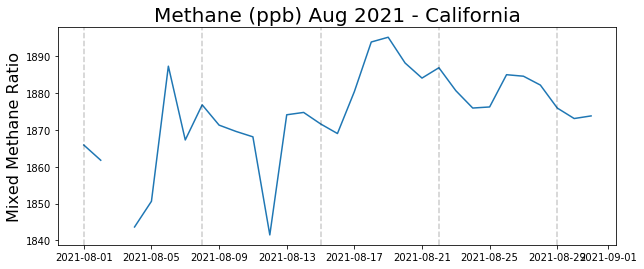

In [7]:
plt.figure(figsize=(10,4))
plt.plot(gdf_time)
plt.title('Methane (ppb) Aug 2021 - California', fontsize=20)
plt.ylabel('Mixed Methane Ratio', fontsize=16)
for date in date_range:
    plt.axvline(date, color='k', linestyle='--', alpha=0.2)

### Remove Trend

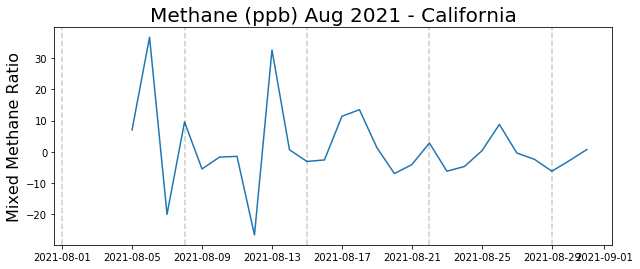

In [8]:
first_diff = lim_methane.diff()[1:]
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Methane (ppb) Aug 2021 - California', fontsize=20)
plt.ylabel('Mixed Methane Ratio', fontsize=16)
for date in date_range:
    plt.axvline(date, color='k', linestyle='--', alpha=0.2)

### Train and Test Set

In [9]:
train_end = datetime(2021,8,25)
test_end = datetime(2021,9,1)

test_data = lim_methane[train_end + timedelta(days=1):test_end]
test_data

,methane_mixing_ratio_bias_corrected
time_utc,
2021-08-26,1885.032581
2021-08-27,1884.623396
2021-08-28,1882.214990
2021-08-29,1875.967664
2021-08-30,1873.118337
2021-08-31,1873.828397


### Make Predictions

In [10]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 4)

rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_methane[:train_end]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

Text(0, 0.5, 'Error')

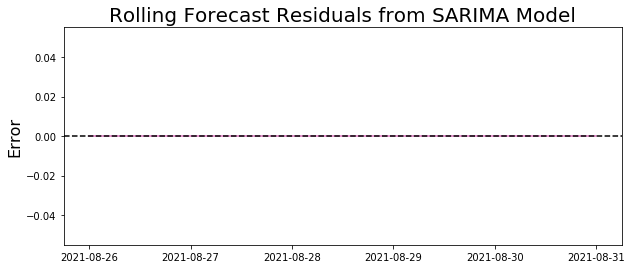

In [11]:
rolling_residuals = test_data - rolling_predictions
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

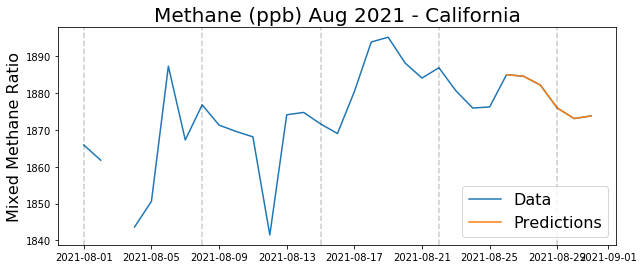

In [12]:
plt.figure(figsize=(10,4))
plt.plot(lim_methane)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('Methane (ppb) Aug 2021 - California', fontsize=20)
plt.ylabel('Mixed Methane Ratio', fontsize=16)
for date in date_range:
    plt.axvline(date, color='k', linestyle='--', alpha=0.2)

In [13]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals['methane_mixing_ratio_bias_corrected']/test_data['methane_mixing_ratio_bias_corrected'])),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals['methane_mixing_ratio_bias_corrected']**2)))

Mean Absolute Percent Error: 0.0
Root Mean Squared Error: 0.0


### Detecting the Anomaly

<hr>
<hr>

## Seasonality-Trend Decomposition using LOESS (STL)


* https://www.youtube.com/watch?v=1NXryMoU7Ho
* https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb

In [29]:
gdf_time

,methane_mixing_ratio_bias_corrected
time_utc,
2021-08-01,1865.911443
2021-08-02,1861.778626
2021-08-03,NaN
2021-08-04,1843.632174
2021-08-05,1850.621098
2021-08-06,1887.348444
2021-08-07,1867.290639
2021-08-08,1876.842606
2021-08-09,1871.324816


In [14]:
from statsmodels.tsa.seasonal import STL
# !pip install statsmodels==0.12.1

In [28]:
stl = STL(gdf_time)
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid

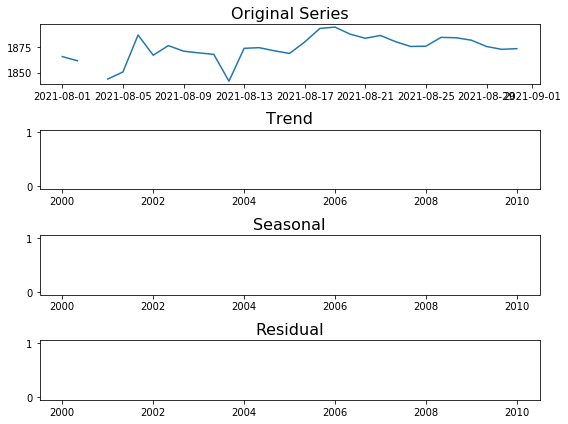

In [22]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(gdf_time)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

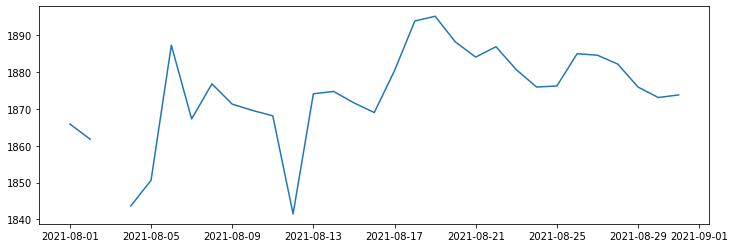

In [24]:
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(gdf_time)
plt.plot(estimated)

### Anomaly Detection

In [25]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

(731459.0, 737760.0)

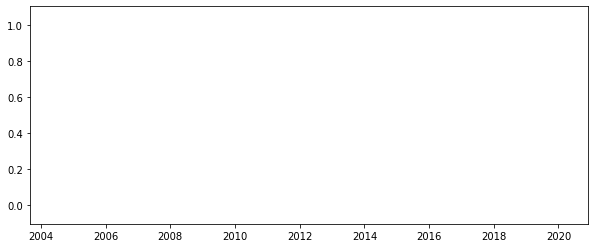

In [26]:
plt.figure(figsize=(10,4))
plt.plot(resid)
plt.fill_between([datetime(2003,1,1), datetime(2021,8,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2003,9,1), datetime(2020,12,1))

In [32]:
anomalies = gdf_time[(resid < lower) | (resid > upper)]

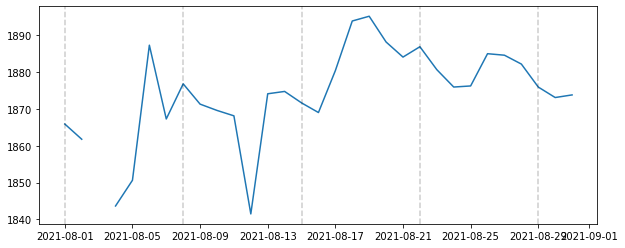

In [36]:
plt.figure(figsize=(10,4))
plt.plot(gdf_time)
    
for date in date_range:
    plt.axvline(date, color='k', linestyle='--', alpha=0.2)
    
plt.scatter(anomalies.index, anomalies.methane_mixing_ratio_bias_corrected, color='r', marker='D')

In [37]:
anomalies

,methane_mixing_ratio_bias_corrected
time_utc,
